In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from os.path import join

proj_path = "/content/drive/MyDrive/air/AirQualityVision"

%cd "{proj_path}"
%pwd

/content/drive/MyDrive/air/AirQualityVision


'/content/drive/MyDrive/air/AirQualityVision'

In [15]:
!git config user.email "piep3147@gmail.com"
!git config user.name "coldchocolate"

In [16]:
!git status

On branch main

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	cnn1.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git init
!git remote add origin https://github.com/coldchocolate/AirQualityVision.git
!git branch
!git checkout -b main

Reinitialized existing Git repository in /content/drive/MyDrive/air/AirQualityVision/.git/
error: remote origin already exists.
Switched to a new branch 'main'


In [11]:
!git add cnn1.ipynb
!git commit -m "cnn1 initial commit"
!git push origin main

fatal: pathspec 'cnn1.ipynb' did not match any files
On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/coldchocolate/AirQualityVision.git'


In [ ]:
import os
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

import skimage.transform as skit
from PIL import Image
from torchvision import transforms

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
#데이터 가져오기
df_aircondition = pd.read_csv('/content/drive/MyDrive/air/airQuality.csv')

# #null 채우기
# df_columns = df_aircondition.columns
# imputer = KNNImputer(n_neighbors=3)
# df_imputer = imputer.fit_transform(df_aircondition)
# df_aircondition = pd.DataFrame(df_imputer,columns=df_columns)

csv_data = df_aircondition.pivot(index='MSRDT', columns='MSRSTE_NM', values=['PM10', 'PM25'])
csv_data.columns = [f"{col[1]}{col[0]}" for col in csv_data.columns]
csv_data.head()

In [ ]:
scaler = MinMaxScaler()
feature = csv_data.copy()

scaled_csv = scaler.fit_transform(feature)
csv_data = pd.DataFrame(scaled_csv, columns=feature.columns, index=feature.index)

#인덱스 int->string으로 수정
csv_data.index = csv_data.index.map(str)
csv_data.head()

In [ ]:
csv_data.index

In [ ]:
class ImgPreprocess:
    def __init__(self, img_directory):
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),  # 이미지 크기 조정
            transforms.ToTensor(),          # 이미지를 Tensor로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #0~1사이로 만들어서 해보기
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.directory = img_directory

    # 1. 이미지를 전처리하여 크기 조정 및 텐서 변환
    def resize(self, image_files):
        images = []
        for img_file in image_files:
            img_path = os.path.join(self.directory, img_file)
            image = Image.open(img_path).convert("RGB")  # 이미지를 로드하고 RGB로 변환
            image = self.preprocess(image)  # 전처리 적용
            images.append(image)
        return images

    # 2. 파일명을 날짜 및 시간별로 그룹화
    def sort_img(self):
        img_dataset = {}
        for img_file in os.listdir(self.directory):
            if img_file.endswith(".JPG"):
                date_time = img_file[:12]  # 파일명에서 날짜와 시간 추출 (YYYYMMDDHHMM)

                if date_time not in img_dataset:
                    img_dataset[date_time] = []

                img_dataset[date_time].append(img_file)
        return img_dataset

    # 3. 전처리 과정을 모두 실행
    def preprocess_img(self):
        # 이미지를 날짜 시간별로 그룹화
        sorted_images = self.sort_img()

        # 각 그룹에 대해 전처리 적용
        processed_images = {}
        for date_time, image_files in sorted_images.items():
            processed_images[date_time] = self.resize(image_files)

        return processed_images

# 사용
img_directory = '/content/drive/MyDrive/air/air_img_all'
img_preprocessor = ImgPreprocess(img_directory)
processed_images = img_preprocessor.preprocess_img()

In [ ]:
# processed_images의 date_time 타입 및 값 확인
print("Sample date_time from processed_images:")
for date_time in processed_images.keys():
    print(date_time, type(date_time))
    break  # 첫 번째 요소만 확인

# csv_data.index의 date_time 타입 및 값 확인
print("\nSample date_time from csv_data.index:")
for date_time in csv_data.index:
    print(date_time, type(date_time))
    break  # 첫 번째 요소만 확인

In [ ]:
matched = 0
total = 0
for date_time in processed_images.keys():
    if date_time in csv_data.index:
        matched += 1
    total += 1
print(f"Matched {matched} out of {total} date_time entries.")

In [ ]:
empty_csv = np.zeros(len(csv_data.columns))
matched_images = []
matched_csv = []

for date_time, images in processed_images.items():
    if date_time in csv_data.index:
        csv_values = csv_data.loc[date_time].values
    else:
        csv_values = empty_csv

    for img in images:
        matched_images.append(img)
        matched_csv.append(csv_values)

matched_images = torch.stack(matched_images)
matched_csv = torch.tensor(matched_csv, dtype=torch.float32)

train_images, valid_images, train_labels, valid_labels = train_test_split(matched_images, matched_csv, test_size=0.2, random_state=42)
valid_images, test_images, valid_labels, test_labels = train_test_split(valid_images, valid_labels, test_size=0.5, random_state=42)

train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)
test_dataset = TensorDataset(test_images, test_labels)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
matched_csv

In [ ]:
print(f"Total images: {len(matched_images)}")
print(f"Total labels: {len(matched_csv)}")

In [ ]:
for images, labels in train_loader:
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score

In [ ]:
class CNN(nn.Module):
    def __init__(self, base_dim, output_size):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=base_dim, kernel_size=7),
            nn.ReLU(),
            nn.Conv2d(in_channels=base_dim, out_channels=base_dim*2, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=base_dim*2, out_channels=base_dim*4, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(base_dim*4*50*50, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        out = self.layer(x)
        batch_size = x.size(0)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)

        return out

In [ ]:
#loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weight):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        weights = 1 + self.weight * (targets > 0.8).float()
        return torch.mean(weights * (inputs - targets) ** 2)

In [ ]:
# MAE
def calculate_mae(pred,y):
    return torch.mean(torch.abs(pred - y)).item()

class WeightedMAE(nn.Module):
    def __init__(self, weight):
        super(WeightedMAE, self).__init__()
        self.weight = weight

    def forward(self, pred, y):
        # y > 0.8인 경우에 가중치를 추가
        weights = 1 + self.weight * (y > 0.85).float()
        return torch.mean(weights * torch.abs(pred - y))

class MAE(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, y):
        return torch.mean(torch.abs(pred - y))
# R2
def calculate_r2_score(pred, y):
    """
    R² 스코어를 계산하는 함수.

    Args:
        pred (torch.Tensor): 예측값
        y (torch.Tensor): 실제값

    Returns:
        float: R² 스코어
    """
    pred = pred.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return r2_score(y, pred)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size=32
output_size = len(csv_data.columns)
model = CNN(8,output_size).to(device)

loss_func = MAE()

learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batchs,leave=False)
    train_loss, total_mae, total_r2 = 0.0, 0.0, 0.0
    for batch, (x,y) in enumerate(dataloader):
        x,y = x.to(device), y.to(device)

        # y_transformed = torch.log1p(y)

        pred = model(x)
        loss = loss_func(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # pred_original = torch.expm1(pred)

        train_loss += loss.item()
        total_mae += calculate_mae(pred,y)
        total_r2 += calculate_r2_score(pred, y)

        loss, current = loss.item(), (batch+1) * len(x)

        pbar.set_description(f"- Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}")
        pbar.update(1)
    pbar.close()

    train_loss /= num_batchs
    train_mae = total_mae / num_batchs
    train_r2 = total_r2 / num_batchs
    return train_loss, train_mae,train_r2

In [ ]:
# x, y = next(iter(train_loader))  # train_loader에서 한 배치만 가져옴
# x, y = x.to(device), y.to(device)

# # 모델 예측
# pred = model(x)

# # 차원 확인
# print(f"Pred shape: {pred.shape}")  # 예측값의 차원 확인
# print(f"Y shape: {y.shape}")        # 실제값의 차원 확인
# print(f"First few predictions: {pred[:5]}")  # 예측값 일부 확인
# print(f"First few true values: {y[:5]}")

In [ ]:
def valid(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    model.eval()
    val_loss, total_mae, total_r2 = 0.0,0.0,0.0
    with torch.no_grad():
        for x,y in dataloader:
            x,y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_func(pred,y).item()
            total_mae += calculate_mae(pred,y)
            total_r2 += calculate_r2_score(pred,y)

        val_loss /= num_batchs
        val_mae = total_mae/num_batchs
        val_r2 = total_r2/ num_batchs
        if show:
            print(f" =Validation[{epoch}]: val_loss = {val_loss:>5f}")
        else:
            return val_loss, val_mae, val_r2

In [ ]:
num_epoch = 20

history = {'loss':[], 'val_loss':[], 'train_mae':[], 'val_mae':[], 'train_r2':[], 'val_r2':[]}
for t in range(num_epoch):
    train_loss, train_mae,train_r2 = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss,val_mae, val_r2 = valid(valid_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)
    print(f"#Training[{t+1}/{num_epoch}]: loss= {train_loss:>5f}, val_loss= {val_loss:>5f}, train_mae={train_mae:>5f}, val_mae={val_mae:>5f}, train_r2={train_r2:>5f}, val_r2={val_r2:>5f}")

  0%|          | 0/19 [00:00<?, ?it/s]

#Training[1/20]: loss= 0.248415, val_loss= 0.185880, train_mae=0.248415, val_mae=0.185880, train_r2=-0.829946, val_r2=-0.199246


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[2/20]: loss= 0.198221, val_loss= 0.202617, train_mae=0.198221, val_mae=0.202617, train_r2=-0.050897, val_r2=-0.288949


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[3/20]: loss= 0.185206, val_loss= 0.185691, train_mae=0.185206, val_mae=0.185691, train_r2=-0.017730, val_r2=-0.063577


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[4/20]: loss= 0.169421, val_loss= 0.159834, train_mae=0.169421, val_mae=0.159834, train_r2=0.159267, val_r2=0.088287


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[5/20]: loss= 0.149927, val_loss= 0.148965, train_mae=0.149927, val_mae=0.148965, train_r2=0.299526, val_r2=0.168822


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[6/20]: loss= 0.144531, val_loss= 0.146948, train_mae=0.144531, val_mae=0.146948, train_r2=0.363616, val_r2=0.230429


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[7/20]: loss= 0.131125, val_loss= 0.145011, train_mae=0.131125, val_mae=0.145011, train_r2=0.438392, val_r2=0.072366


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[8/20]: loss= 0.122341, val_loss= 0.165137, train_mae=0.122341, val_mae=0.165137, train_r2=0.523369, val_r2=0.082920


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[9/20]: loss= 0.114257, val_loss= 0.156359, train_mae=0.114257, val_mae=0.156359, train_r2=0.549464, val_r2=0.150777


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[10/20]: loss= 0.104650, val_loss= 0.148260, train_mae=0.104650, val_mae=0.148260, train_r2=0.603700, val_r2=0.181208


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[11/20]: loss= 0.098946, val_loss= 0.151433, train_mae=0.098946, val_mae=0.151433, train_r2=0.646365, val_r2=0.089409


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[12/20]: loss= 0.090813, val_loss= 0.168443, train_mae=0.090813, val_mae=0.168443, train_r2=0.686857, val_r2=-0.013606


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[13/20]: loss= 0.097400, val_loss= 0.175623, train_mae=0.097400, val_mae=0.175623, train_r2=0.659759, val_r2=-0.214292


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[14/20]: loss= 0.089571, val_loss= 0.144461, train_mae=0.089571, val_mae=0.144461, train_r2=0.692335, val_r2=0.047663


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[15/20]: loss= 0.081916, val_loss= 0.144447, train_mae=0.081916, val_mae=0.144447, train_r2=0.736394, val_r2=0.186561


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[16/20]: loss= 0.077031, val_loss= 0.152026, train_mae=0.077031, val_mae=0.152026, train_r2=0.755582, val_r2=0.161090


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[17/20]: loss= 0.071216, val_loss= 0.153883, train_mae=0.071216, val_mae=0.153883, train_r2=0.781552, val_r2=0.056331


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[18/20]: loss= 0.068669, val_loss= 0.142179, train_mae=0.068669, val_mae=0.142179, train_r2=0.793142, val_r2=0.115913


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[19/20]: loss= 0.063377, val_loss= 0.150224, train_mae=0.063377, val_mae=0.150224, train_r2=0.814266, val_r2=0.128395


  0%|          | 0/19 [00:00<?, ?it/s]

#Training[20/20]: loss= 0.065709, val_loss= 0.149738, train_mae=0.065709, val_mae=0.149738, train_r2=0.797480, val_r2=-0.143884


In [ ]:
def test(test_loader, model):
    num_batches = len(test_loader)
    pred_row = []
    label_row = []
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(device), y.to(device)
            pred = model(x)

            inverse_pred = scaler.inverse_transform(pred.cpu().numpy())#이게 될까?
            label = scaler.inverse_transform(y.cpu().numpy())
            pred_row.append(np.floor(inverse_pred))
            label_row.append(np.floor(label))

    pred_row = np.concatenate(pred_row, axis=0)
    label_row = np.concatenate(label_row, axis=0)
    return pred_row, label_row

def table(pred_row, label_row):
    merged =[]
    idx_columns = []
    for i, (pred, label) in enumerate(zip(pred_row, label_row)):
        merged.append(pred)
        idx_columns.append(f"pred{i+1}")
        merged.append(label)
        idx_columns.append(f"label{i+1}")

    df_table = pd.DataFrame(merged, index = idx_columns, columns = csv_data.columns)
    return df_table

In [ ]:
epoch=1

for i in range(epoch):
    pred_row, label_row= test(test_loader, model)
    table = table(pred_row, label_row)

In [ ]:
table

,광진구PM10,동대문구PM10,성북구PM10,송파구PM10,중랑구PM10,광진구PM25,동대문구PM25,성북구PM25,송파구PM25,중랑구PM25
pred1,16.0,22.0,17.0,16.0,18.0,11.0,13.0,11.0,18.0,9.0
label1,31.0,28.0,21.0,27.0,23.0,25.0,22.0,17.0,23.0,18.0
pred2,28.0,30.0,32.0,32.0,28.0,18.0,20.0,18.0,26.0,19.0
label2,29.0,33.0,31.0,29.0,30.0,20.0,23.0,22.0,15.0,21.0
pred3,11.0,13.0,9.0,9.0,9.0,4.0,6.0,2.0,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...
label72,24.0,26.0,26.0,32.0,25.0,14.0,17.0,12.0,25.0,17.0
pred73,13.0,19.0,20.0,9.0,14.0,10.0,4.0,6.0,11.0,7.0
label73,15.0,16.0,11.0,16.0,14.0,11.0,7.0,1.0,15.0,5.0
pred74,10.0,14.0,5.0,11.0,10.0,4.0,5.0,1.0,4.0,6.0


In [ ]:
# x, y = next(iter(test_loader))
x = [x for x,y in test_loader]
x_img = torch.cat(x, dim=0)
x_img.shape

torch.Size([74, 3, 224, 224])

In [ ]:
num_columns = len(pred_row[0])
x = np.arange(num_columns)  #10개
width = 0.2  # 막대 너비
columns =['PM10','PM10','PM10','PM10','PM10','PM25','PM25','PM25','PM25','PM25']

class Result:
    def __init__(self, pred_row, label_row, x_img, number):
        self.num = number
        self.x_img = x_img
        self.pred_row = pred_row
        self.label_row = label_row

    def autolabel(self, rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 텍스트의 y 위치 조정
                        textcoords="offset points",
                        ha='center', va='bottom')

    def show_all(self, x, width, columns):
        fig, ax = plt.subplots()

        rects1 = ax.bar(x - width/2, self.pred_row[self.num], width, label='Predictions', color='salmon', alpha=0.7)
        rects2 = ax.bar(x + width/2, self.label_row[self.num], width, label='Labels', color='skyblue', alpha=0.7)

        # 축과 레이블 설정
        ax.set_ylabel('Value')
        ax.set_title('Predictions vs Labels')
        ax.set_xticks(x)
        ax.set_xticklabels(columns, rotation=45)
        ax.legend()

        # 막대 위에 값 표시
        self.autolabel(rects1, ax)
        self.autolabel(rects2, ax)
        plt.show()

        # 이미지 표시
        plt.imshow(self.x_img[self.num].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Image {self.num}")
        plt.axis('off')  # 축 숨기기 (선택 사항)
        plt.show()


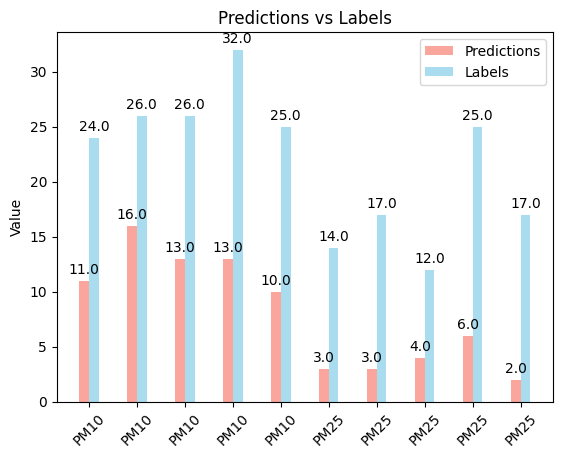

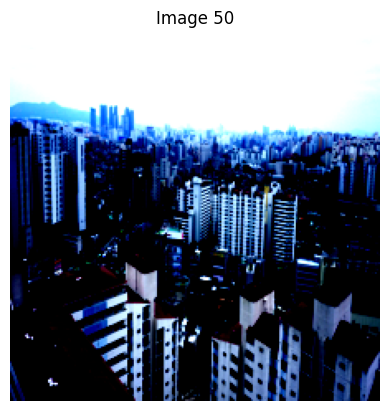

In [ ]:
# 클래스 인스턴스 생성
result = Result(pred_row, label_row, x_img, 50)

# 그래프와 이미지 표시
result.show_all(x, width, columns)